In [36]:
import os
os.environ['NOTEBOOK_MODE'] = '1'
import sys
import torch as ch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import seaborn as sns
from scipy import stats
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
from robustness import model_utils, datasets
from robustness.tools.vis_tools import show_image_row, show_image_column
from robustness.tools.label_maps import CLASS_DICT
from user_constants import DATA_PATH_DICT
%matplotlib inline

In [37]:
# Constants
DATA = 'CIFAR'
BATCH_SIZE = 8
NUM_WORKERS = 8
PATCH_SIZE = 9

DATA_SHAPE = 224 # Image size (fixed for dataset)
REPRESENTATION_SIZE = 2048 # Size of representation vector (fixed for model)

In [38]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(DATA_PATH_DICT[DATA])
_, test_loader = dataset.make_loaders(workers=NUM_WORKERS, 
                                      batch_size=BATCH_SIZE, 
                                      data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [39]:
# Load model
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path': f'./models/{DATA}.pt'
}

model, _ = model_utils.make_and_restore_model(**model_kwargs)
model.eval()
pass

=> loading checkpoint './models/CIFAR.pt'
=> loaded checkpoint './models/CIFAR.pt' (epoch 153)


In [40]:
# Function to get corrupted image
def mask_image(x, width=PATCH_SIZE):
#     print(x.shape[-1]-)
    loc = np.random.randint(0, x.shape[-1] - PATCH_SIZE, size=(x.shape[0], 2))
    mask = ch.zeros_like(x)
    for idx in range(x.shape[0]):
        i, j = loc[idx, 0], loc[idx, 1]
        val = ch.mean(ch.mean(x[idx, :], dim=2, keepdim=True), dim=1, keepdim=True)
        # Initialize masked region as mean pixel value over image (per channel)
        x[idx, :, i:i+PATCH_SIZE, j:j+PATCH_SIZE] = val.expand_as(x[idx, :, i:i+PATCH_SIZE, j:j+PATCH_SIZE])
        mask[idx, :, i:i+PATCH_SIZE, j:j+PATCH_SIZE] = 1
    return x, mask

In [41]:
# Custom inpainting loss
def inpainting_loss_wrapper(im_targ, mask, normalizer, lambdar=10):
    def inpainting_loss(mod, inp, targ):
        op = mod(normalizer(inp), fake_relu=True)
        loss = ch.nn.CrossEntropyLoss(reduction='none')(op, targ)
        loss_l2 = ((im_targ - inp) * (1 - mask) )**2
        loss_l2 = loss_l2.mean(-1).mean(-1).mean(-1)
        loss += lambdar * loss_l2
        return loss, None
    return inpainting_loss

In [42]:
# PGD parameters
kwargs = {
        'constraint':'2',
        'eps': 21.6,
        'step_size': 0.1,
        'iterations': 720, 
        'do_tqdm': True,
        'targeted': True,
        'should_normalize': False
}

In [43]:
# Inpainting using PGD
_, (img_orig, targ_orig) = next(data_iterator)
img_corrupt, mask = mask_image(img_orig.clone())

kwargs['custom_loss'] = inpainting_loss_wrapper(img_corrupt.cuda(), 
                                                mask.cuda(), 
                                                model.module.normalizer)

_, img_inpaint = model(img_corrupt, targ_orig.clone(), make_adv=True, **kwargs)

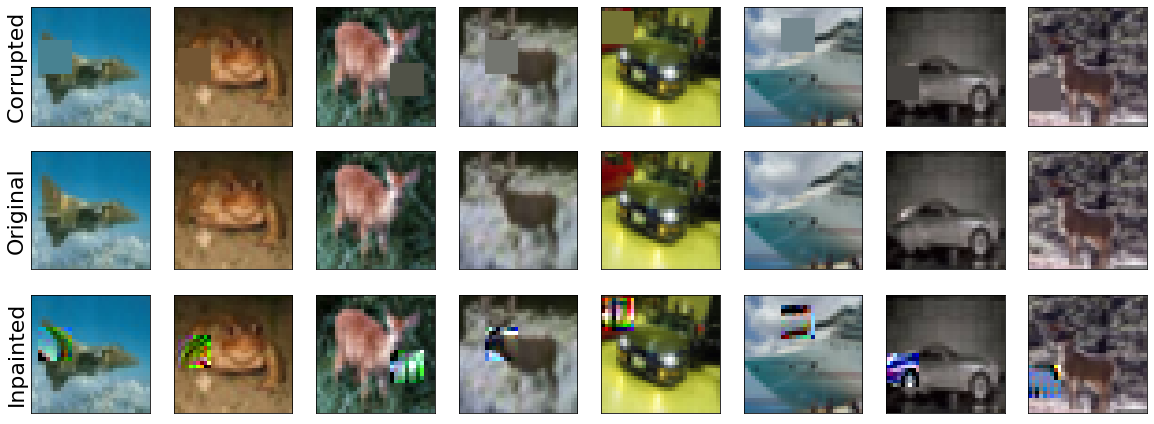

In [44]:
# Visualize inpainted images
show_image_row([img_corrupt.cpu(), img_orig.cpu(), img_inpaint.detach().cpu()], 
               ["Corrupted", "Original", "Inpainted"],
               fontsize=22)